## Lesson 22:
### Exercise 1: Galaxies vs Quasars with neural networks

In [21]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import seaborn as sns
%config InlineBackend.figure_format='retina'

c = sns.color_palette('Paired', 7)
plt.rcParams['figure.figsize'] = (8, 5)

#------------------- Function to read the data -------------------
def Dataframe(namefile):                                        #-
    df = pd.read_csv(namefile, sep=',', skipinitialspace=True)  #-
    return df                                                   #-
#-----------------------------------------------------------------

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=False)


In [22]:
data = Dataframe("galaxyquasar.csv")
data = data.dropna()
num_rows = len(data.index)

In [36]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])
classes = np.where(data['class']=='QSO', 1, 0) # 1 is QSO, 0 is GALAXY

# add those as dataframe columns
data['u-g'] = u_g
data['g-r'] = g_r
data['r-i'] = r_i
data['i-z'] = i_z
data['class_num'] = classes

X = data.loc[:, ['u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y = data.loc[:, ['class_num']].to_numpy()

### Data normalization + training/test split
We can split the entire dataset into a **training set** and a **test set** using the Scikit Learn *train_test_split* function. $30\%$ of the data goes into the test set. But first we normalize our dataset so that it has zero mean and unit variance in every dimension. This can also be done using te usual *StandardScaler* module of *Scikit-learn*

In [7]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Normalization

2024-06-13 17:57:17.271920: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 17:57:17.273437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 17:57:17.300960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 17:57:17.301806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 17:57:17.770534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [37]:
normalizer = Normalization(axis=-1)
normalizer.adapt(X)
X_scaled = np.array(normalizer(X))
print(X_scaled)

[[-1.6009315  -2.1856418  -0.5065469  -0.6597548 ]
 [ 0.8389082   1.1876656   0.41731626  0.47661254]
 [ 0.7716434   0.50527114 -0.04953469 -0.14751536]
 ...
 [ 0.01402752 -0.6316651  -0.43134817 -0.1131583 ]
 [-0.06667943  0.08235198  0.26992127 -0.17028071]
 [-0.47648627 -0.89827895 -0.71412855 -0.5216425 ]]


In [48]:
# 30% test set, 70% training set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state=42)
print('Training dataset: ')
print(X_train)
print('\nShape of train:')
print(X_train.shape)
print('\nTest dataset: \n')
print(X_test)
print('\nShape of test:')
print(X_test.shape)

Training dataset: 
[[-0.25857967 -0.42241818 -0.07498585 -0.15694074]
 [ 0.04050914  0.7225612   0.5851738   0.2751449 ]
 [-0.45488775  0.2466035   0.3954218  -0.12733439]
 ...
 [-0.11176035 -0.532759   -0.39111596 -0.15777688]
 [ 0.2232835   0.04969563 -0.26626214 -0.2842215 ]
 [-2.1775286  -1.6597466  -0.00537629 -0.62349755]]

Shape of train:
(35000, 4)

Test dataset: 

[[-0.25038645  0.45543054  0.17860198  0.25781438]
 [ 0.4563877   0.10218507  0.18474531  0.20890112]
 [-1.8718194  -1.3098927  -0.75154316 -0.8665433 ]
 ...
 [ 1.0172385   0.6242687   0.23158284  0.33386356]
 [ 1.0394042   0.80974203  0.40521422  0.42728132]
 [ 0.85955596  0.77159435  0.6788487   0.54962134]]

Shape of test:
(15000, 4)


In [136]:
def pred_visualization(X_test, y_test, y_p):
    fig = plt.figure()
    
    galaxies = (y_p == 0)

    plt.scatter(X_test[galaxies][:, 0], X_test[galaxies][:, 1], 
            s=10, edgecolors='none', alpha=0.5, 
            label='Galaxy', color=c[3])

    plt.scatter(X_test[~galaxies][:, 0], X_test[~galaxies][:, 1], 
            s=10, edgecolors='none', alpha=0.5, 
            label='QSO', color=c[6])
    
    plt.xlim(-4, 3)
    plt.ylim(-5, 5)
    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.legend(loc='best', fontsize=10, frameon=True)
    plt.grid(True, ls='--', alpha=0.2)

In [69]:
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1]),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile it
model.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])
# Fit
history = model.fit(X_train, y_train,
                   epochs=25)

Epoch 1/25
1094/1094 [==============================] - 1s 526us/step - loss: 0.4532 - accuracy: 0.8396
Epoch 2/25
1094/1094 [==============================] - 1s 504us/step - loss: 0.1277 - accuracy: 0.9720
Epoch 3/25
1094/1094 [==============================] - 1s 520us/step - loss: 0.0858 - accuracy: 0.9786
Epoch 4/25
1094/1094 [==============================] - 1s 510us/step - loss: 0.0765 - accuracy: 0.9800
Epoch 5/25
1094/1094 [==============================] - 1s 520us/step - loss: 0.0735 - accuracy: 0.9798
Epoch 6/25
1094/1094 [==============================] - 1s 501us/step - loss: 0.0727 - accuracy: 0.9807
Epoch 7/25
1094/1094 [==============================] - 1s 502us/step - loss: 0.0716 - accuracy: 0.9810
Epoch 8/25
1094/1094 [==============================] - 1s 521us/step - loss: 0.0717 - accuracy: 0.9808
Epoch 9/25
1094/1094 [==============================] - 1s 499us/step - loss: 0.0709 - accuracy: 0.9813
Epoch 10/25
1094/1094 [==============================] - 1s 524u

In [135]:
y_pred = model.predict(X_test)

# We approximate every value below 0.5 to 0 and above 0.5 to 1
y_pred_binary = np.array(tf.round(y_pred)).ravel()

469/469 [==============================] - 0s 321us/step


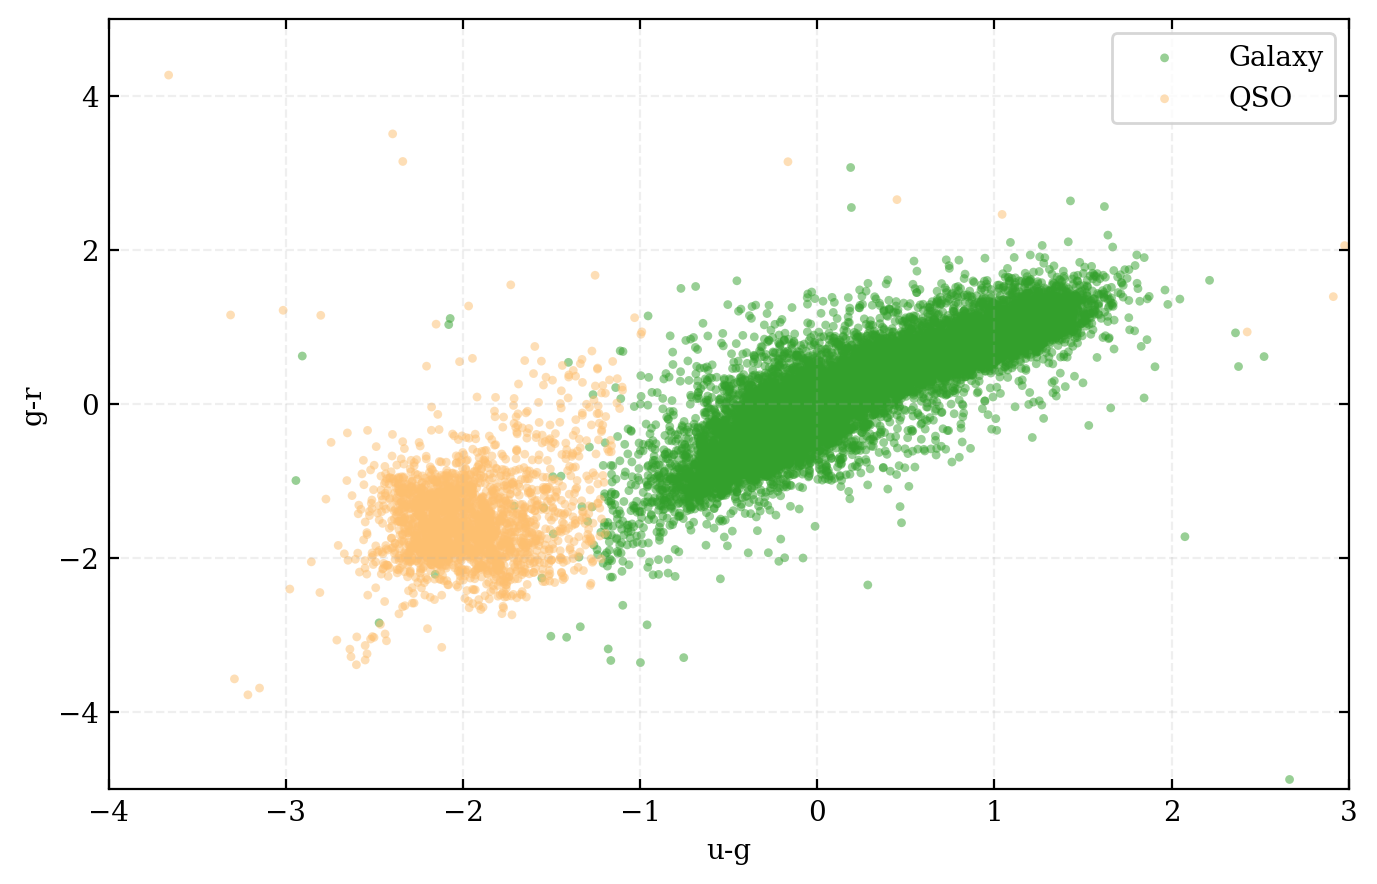

In [137]:
pred_visualization(X_test, y_test, y_pred_binary)

Now we evaluate the model on the test set

In [138]:
loss, accuracy = model.evaluate(X_test, y_test)

469/469 [==============================] - 0s 455us/step - loss: 0.0736 - accuracy: 0.9818


In [139]:
print('The accuracy of our Neural Network Classifier is', round(accuracy*100, 2), '%')

The accuracy of our Neural Network Classifier is 98.18 %


> **That's 2% better with respect to the Random Forest Classifier we used in the previous exercise**

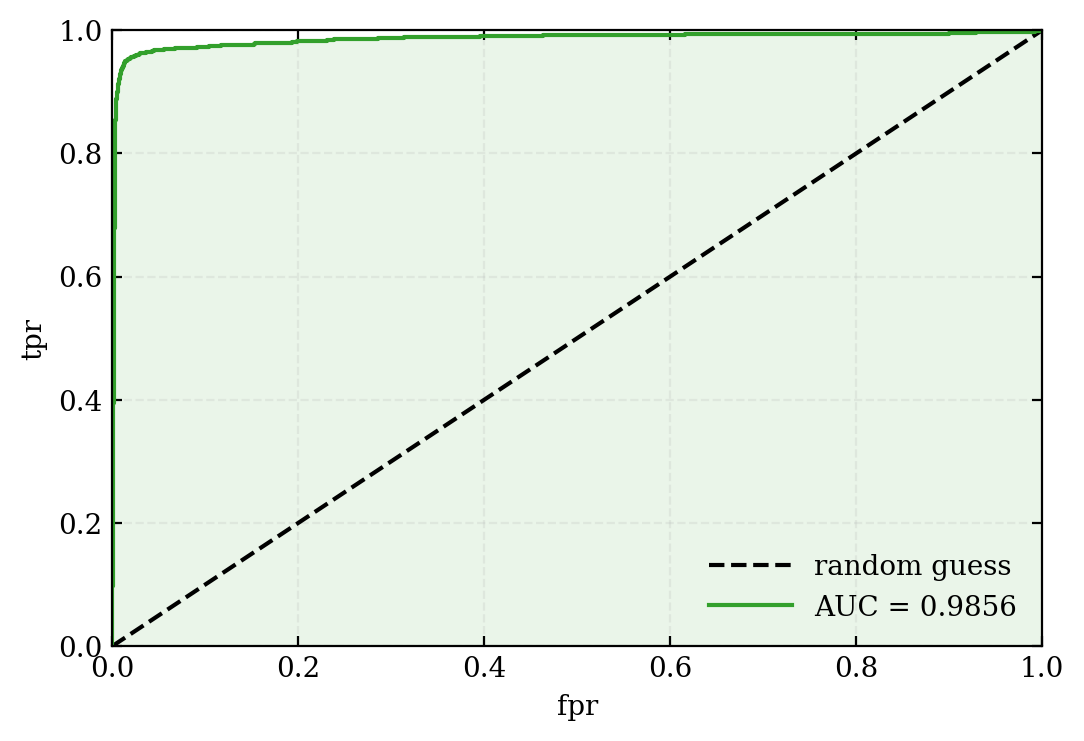

In [147]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot([0,1], [0,1], '--k', label='random guess')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_tf = auc(fpr, tpr)

ax.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_tf), color=c[3])
ax.fill_between(fpr, tpr, color=c[3], alpha=0.1)
ax.set_xlabel('fpr');
ax.set_ylabel('tpr');
ax.legend(loc='lower right', frameon=False);
ax.grid(True, ls='--', alpha=0.2)

plt.show()